In [7]:
import os
os.chdir('/rds/homes/g/gaddcz/Projects/mmVAE/src/')
save_path = f'/rds/homes/g/gaddcz/Projects/mmVAE/scripts/figs/study1/'

import torch
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pickle as pkl

from model import helpers
from model.plotting import *

torch.manual_seed(0)
np.random.seed(0)
%matplotlib inline

In [8]:
# LOAD DATA AND RE-ARRANGE COLUMN ORDER (for plotting)
diag_frame = pd.read_csv('/rds/homes/g/gaddcz/MumPredictPreprocessing/multico_bin.csv')[helpers.get_column_order()]
diag_frame = diag_frame[diag_frame.sum(axis = 1) >= 2]          # Filter - Only include patients that have 2 or more diseases diagnosed.

# LOAD DIAGNOSIS DATE INFORMATION AND RE-ARRANGE COLUMN ORDER (for plotting)
try:
    ## This csv file has columns 'Date_[disease]' and entries are either NaN (if no disease), or dd/mm/yyyy (if diagnosis).
    # It is just used for analysis in post processing, it is optional
    date_frame = pd.read_csv('/rds/homes/g/gaddcz/MumPredictPreprocessing/multico_date.csv')[['Date_' + d for d in helpers.get_column_order()]]
    date_frame = date_frame.loc[diag_frame.index]
    #date_frame = date_frame.fillna('nat')
except :
    print("Not using date")
    date_frame = None

diag_frame.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')
if date_frame is not None: 
    date_frame.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')
    
    
Y = diag_frame.to_numpy()

print(f"N={Y.shape[0]}")

# Check prevalence of diseases after any filtering
print("Counts of health health conditions")
print(list(zip(diag_frame.columns, diag_frame.to_numpy().sum(axis=0))))


N=290812
Counts of health health conditions
[('CancerAll', 2890), ('asthmalonglist2018', 85395), ('female_infertility', 24125), ('AllergicRhinConj', 92404), ('migraine', 64686), ('AnxietyPTSDdiag', 97255), ('depressionDiag', 133090), ('substance_misuse', 11638), ('alcoholproblem', 5683), ('eatingdisorderuom', 11645), ('SMHmm', 11108), ('OthMental', 47124), ('OthHeadache', 23626), ('AdrenalAll', 62), ('Pituitary', 2010), ('pcoskoo', 21012), ('sarcoid', 292), ('leiomyoma', 3338), ('endometriosis', 10507), ('retinal_detach', 473), ('pth', 134), ('hfincidenceprevkoo', 383), ('IHD_MI', 664), ('stroketiaincidprevkoo', 1010), ('interstitiallungdiseasemm', 50), ('blindmm', 118), ('copd', 323), ('solidorgantransplant', 181), ('bronchiectasisdraftv1', 382), ('NeuroDev', 2542), ('atopiceczema_mm', 16581), ('Cardiomyopathy', 207), ('cf', 239), ('sickle_cell', 119), ('PulmHtn', 45), ('ibs_mm', 49439), ('turnerssyndrome_imrd', 57), ('marfansyndrome_imrd', 125), ('HIVall', 267), ('DiabAll', 5071), ('

In [29]:
print(f"Condition | 1 condition | 2 conditions | 3+ conditions")

for condition_id in diag_frame.columns:
    df_tmp = diag_frame[diag_frame[condition_id]==1]
    cmb, count = np.unique(df_tmp.to_numpy().sum(axis=1), return_counts=True)
    print(f" {condition_id} \t\t {count[0]} &  {count[1]} & {np.sum(count[2:])}")

    # print(cmb)
    # print(count)
    # print(count[:2])
    # print(count[2:])
    # print(np.sum(count[2:]))


Condition | 1 condition | 2 conditions | 3+ conditions
 CancerAll 		 957 &  791 & 1142
 asthmalonglist2018 		 30375 &  22920 & 32100
 female_infertility 		 8893 &  6465 & 8767
 AllergicRhinConj 		 34050 &  24925 & 33429
 migraine 		 21332 &  17406 & 25948
 AnxietyPTSDdiag 		 27634 &  27040 & 42581
 depressionDiag 		 41929 &  37533 & 53628
 substance_misuse 		 2085 &  2559 & 6994
 alcoholproblem 		 928 &  1129 & 3626
 eatingdisorderuom 		 2795 &  2816 & 6034
 SMHmm 		 1294 &  2002 & 7812
 OthMental 		 11746 &  12153 & 23225
 OthHeadache 		 6333 &  6022 & 11271
 AdrenalAll 		 19 &  9 & 34
 Pituitary 		 678 &  481 & 851
 pcoskoo 		 6946 &  5639 & 8427
 sarcoid 		 92 &  78 & 122
 leiomyoma 		 1205 &  846 & 1287
 endometriosis 		 3151 &  2729 & 4627
 retinal_detach 		 157 &  119 & 197
 pth 		 37 &  30 & 67
 hfincidenceprevkoo 		 81 &  91 & 211
 IHD_MI 		 156 &  144 & 364
 stroketiaincidprevkoo 		 266 &  263 & 481
 interstitiallungdiseasemm 		 11 &  13 & 26
 blindmm 		 27 &  22 & 69
 copd 		

In [32]:
# Unique combinations
cmb, count = np.unique(diag_frame.to_numpy(), axis=0, return_counts=True)
print(f"{cmb.shape[0]} unique health condition combinations, across {diag_frame.to_numpy().shape[0]} patients")
        
# Top occurrences of 3 or more diseases
print("Most prevalent combinations:")
for mm_level in [2, 3, 4, 5]:
    print(f"\n{mm_level}+ health conditions")
    data_tmp = diag_frame[diag_frame.sum(axis=1) >= mm_level].to_numpy()
    cmb, count = np.unique(data_tmp, axis=0, return_counts=True)
    for itr, idx in enumerate(np.argsort(-count)):
        conditions = [d for i, d in enumerate(diag_frame.columns) if cmb[idx, i] == 1 ]
        print(f"{itr}: \t {count[idx]} occurrences of combination {conditions}, which is {100*count[idx]/Y.shape[0]:.2f}% of the population")
        if itr > 10:
            break


41893 unique health condition combinations, across 290812 patients
Most prevalent combinations:

2+ health conditions
0: 	 13334 occurrences of combination ['AnxietyPTSDdiag', 'depressionDiag'], which is 4.59% of the population
1: 	 9992 occurrences of combination ['asthmalonglist2018', 'AllergicRhinConj'], which is 3.44% of the population
2: 	 4164 occurrences of combination ['depressionDiag', 'OthMental'], which is 1.43% of the population
3: 	 3799 occurrences of combination ['asthmalonglist2018', 'depressionDiag'], which is 1.31% of the population
4: 	 3703 occurrences of combination ['AllergicRhinConj', 'depressionDiag'], which is 1.27% of the population
5: 	 3432 occurrences of combination ['AllergicRhinConj', 'migraine'], which is 1.18% of the population
6: 	 3163 occurrences of combination ['migraine', 'depressionDiag'], which is 1.09% of the population
7: 	 2717 occurrences of combination ['asthmalonglist2018', 'migraine'], which is 0.93% of the population
8: 	 2715 occurrences

# tSNE plot for visualisatons

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


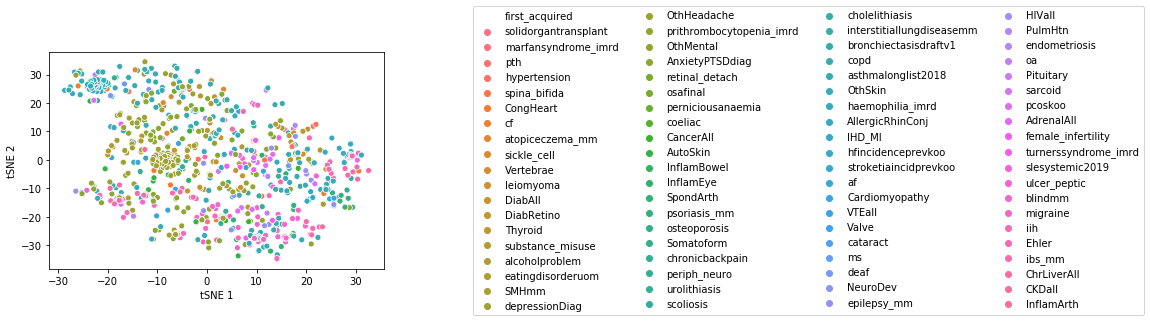

           tSNE 1     tSNE 2  first_acquired
76674  -11.381441   8.710673       OthMental
53380    2.967958 -19.747669        migraine
5168    -2.253197  17.726473  depressionDiag
275643  24.107779  -8.544086         OthSkin
124137   2.847613 -19.838930  depressionDiag


In [3]:
YtSNE = diag_frame.sample(n=1000, random_state=1, replace=False)
latentTSNE = TSNE(n_components=2, init='random').fit_transform(YtSNE)

tSNE = pd.DataFrame(latentTSNE, columns=['tSNE 1', 'tSNE 2'], index=YtSNE.index)

#print(np.all(np.sort(tSNE.index) == np.sort(YtSNE.index)))


if date_frame is not None:
    tSNE_date = date_frame.loc[YtSNE.index]
    tSNE_date = helpers.get_acquired_order(tSNE_date)
    tSNE['first_acquired'] = tSNE_date['first_acquired']
    g = sns.scatterplot(data = tSNE, x = "tSNE 1", y = "tSNE 2", hue='first_acquired', hue_order = helpers.get_column_order()); 
    g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=4)
else:
    sns.scatterplot(data = tSNE, x = "tSNE 1", y = "tSNE 2");  
    
plt.savefig(save_path + 'tSNE.eps', dpi='figure', format='eps')
plt.show()

print(tSNE.head())

# Bar plot to look at distribution of latent mean

In [ ]:
#print(np.sum(return_dict['z_binary'], axis=0))
#print(np.sum(np.sum(return_dict['z_binary'], axis=0)))

z_plt = return_dict['z_binary']
print(z_plt.shape)

for i in range(z_plt.shape[1]):
    plt.xlim((0, 1))
    plt.hist(z_plt[:, i])
    plt.show()
    
for i in range(3):
    print(z_plt[i, :])
    

# Bar plots to look at the distribution of diseases which were first, second, third etc occurrence for selected clusters


In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(helpers.get_column_order())
#print(le.transform(['solidorgantransplant']))

counts = return_dict['counts']
cluster_allocations = return_dict['cluster_allocations']

for idx, cluster in enumerate([i for i in range(len(counts)) if counts[i] > -1]):
    tSNE_cluster_order = tSNE_date[tSNE['cluster'] == cluster + 1]['acquired_order'].to_list()
    if len(tSNE_cluster_order) > 0:
        order_record = np.zeros((5, 79))
        for seq in tSNE_cluster_order:            
            enc_seq = le.transform(seq)
            for ind in range(min((5, len(enc_seq)))):
                order_record[ind, enc_seq[ind]] += 1
        
        order_record = pd.DataFrame(order_record, columns = le.classes_)
        plot_cluster_grid(order_record[helpers.get_column_order()], f"{method}: cluster {cluster} , each row corresponds a subsequent transition", figsize=[2,0.3])


In [ ]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# le.fit(helpers.get_column_order())
# #print(le.transform(['solidorgantransplant']))

# counts = best_dict['counts']
# cluster_allocations = best_dict['cluster_allocations']

# for idx, cluster in enumerate([i for i in range(len(counts)) if counts[i] > -1]):
#     tSNE_cluster_order = tSNE_date[tSNE['cluster'] == cluster + 1]['acquired_order'].to_list()
#     if len(tSNE_cluster_order) > 0:
#         order_record = np.zeros((5, 79))
#         for seq in tSNE_cluster_order:            
#             enc_seq = le.transform(seq)
#             for ind in range(min((5, len(enc_seq)))):
#                 order_record[ind, enc_seq[ind]] += 1
        
#         order_record = pd.DataFrame(order_record, columns = le.classes_)
#         plot_cluster_grid(order_record[helpers.get_column_order()], f"{method}: cluster {cluster} , each row corresponds a subsequent transition", figsize=[2,0.3])
